In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

### Data Loading

In [8]:
# Each record describes characteristics of a client
client = pd.read_csv("../data/raw/client.asc", sep=';')

# Each record describes static characteristics of an account
account = pd.read_csv("../data/raw/account.asc", sep=';')

# Each record describes a credit card issued to an account
card = pd.read_csv("../data/raw/card.asc", sep=';')

# Each record describes demographic characteristics of a district
district = pd.read_csv("../data/raw/district.asc", sep=';')

# Each record relates together a client with an account
# i.e. this relation describes the rights of clients to operate accounts
disp = pd.read_csv("../data/raw/disp.asc", sep=';')

# Each record describes characteristics of a payment order (debits only)
order = pd.read_csv("../data/raw/order.asc", sep=';')

# Each record describes one transaction on an account
trans = pd.read_csv("../data/raw/trans.asc", sep=';')

# Each record describes a loan granted for a given account
loan = pd.read_csv("../data/raw/loan.asc", sep=';')


### Client's Table

In [9]:
client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [10]:
# Extracting birth year from birth number
client['birth_year'] = '19' + client['birth_number'].astype(str).str[:2]
client['birth_year'] = client['birth_year'].astype(int)

# Extracting birth day from birth number
client['birth_day'] = client['birth_number'].astype(str).str[-2:].astype(int)

# Extracting birth month from birth number
client['birth_month'] =client['birth_number'].astype(str).str[2:4].astype(int)

# Extract and correct the gender
client['gender'] = 'M'
client.loc[client['birth_month'] > 50, 'gender'] = 'F'

# Correct the birth month
client.loc[client['birth_month'] > 50, 'birth_month'] = client.loc[client['birth_month'] > 50, 'birth_month'] - 50
# Calculating age by year 1996
client['age'] = 1996 - client['birth_year']
# Creating age groups
client['age_group'] = (client['age'] // 10)*10
#Dropping birth_number col since not needed anymore
client = client.drop('birth_number', axis=1)

In [11]:
# Checking null values
client.isna().sum()

client_id      0
district_id    0
birth_year     0
birth_day      0
birth_month    0
gender         0
age            0
age_group      0
dtype: int64

<AxesSubplot:xlabel='age_group'>

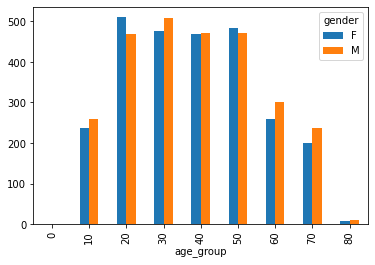

In [12]:
# Grouping clients by age group and gender
client.groupby(['age_group','gender'])['client_id'].count().unstack('gender').plot.bar()

In [13]:
client.head()

,client_id,district_id,birth_year,birth_day,birth_month,gender,age,age_group
0,1,18,1970,13,12,F,26,20
1,2,1,1945,4,2,M,51,50
2,3,1,1940,9,10,F,56,50
3,4,5,1956,1,12,M,40,40
4,5,5,1960,3,7,F,36,30


In [14]:
# Explore account's table

account.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


### Account's Table

In [15]:
account.isna().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

In [16]:
# Replacing frequency code with its meaning
account["frequency"] = account["frequency"].replace(
    {"POPLATEK MESICNE": "Monthly", "POPLATEK PO OBRATU": "Transactional", "POPLATEK TYDNE": "Weekly"})
account["frequency"].unique()

array(['Monthly', 'Transactional', 'Weekly'], dtype=object)

In [17]:
# Extracting the year/month of account opening 
account["year"] = account["date"].astype(str).str[:2].astype(int) + 1900
account["month"] = account["date"].astype(str).str[2:4].astype(int)
account.tail()

,account_id,district_id,frequency,date,year,month
4495,124,55,Monthly,971228,1997,12
4496,3958,59,Monthly,971228,1997,12
4497,777,30,Monthly,971228,1997,12
4498,1573,63,Monthly,971229,1997,12
4499,3276,1,Monthly,971229,1997,12


In [18]:
#Filtering accounts by accts before 1996 in order to use the predefined timeline
account = account.loc[account["year"]< 1996, :]

<AxesSubplot:xlabel='year'>

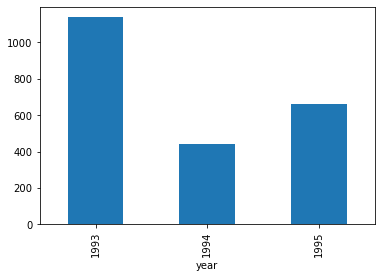

In [19]:
# Grouping account by year
acct_by_year = account.groupby('year')['account_id'].count().plot.bar()
acct_by_year

<AxesSubplot:xlabel='month'>

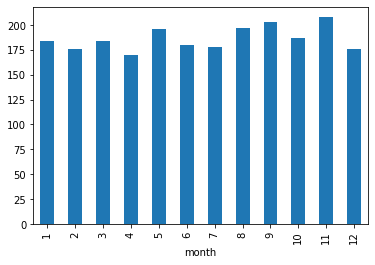

In [20]:
# Get month behavior through the year
acct_by_month = account.groupby('month')['account_id'].count().plot.bar()
acct_by_month

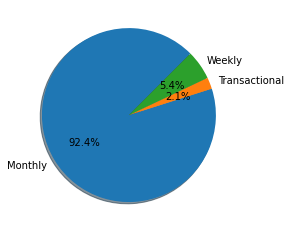

In [21]:
# Accounts by frequency of statements
acct_by_freq = account.groupby('frequency')['account_id'].count()
fig, ax = plt.subplots()
ax.pie(acct_by_freq.values, labels=acct_by_freq.index, autopct='%1.1f%%',
        shadow=True, startangle=45)

plt.show()

## Disp Table

In [22]:
# Merging account with disposition
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [23]:
# Subsetting to obtain only client type = OWNER
disp = disp.loc[disp["type"]== "OWNER", :]
acct_disp = pd.merge(account, disp, on="account_id", how="inner")
acct_disp.head()

,account_id,district_id,frequency,date,year,month,disp_id,client_id,type
0,576,55,Monthly,930101,1993,1,692,692,OWNER
1,3818,74,Monthly,930101,1993,1,4601,4601,OWNER
2,704,55,Monthly,930101,1993,1,844,844,OWNER
3,2378,16,Monthly,930101,1993,1,2873,2873,OWNER
4,2632,24,Monthly,930102,1993,1,3177,3177,OWNER


### Credit Card's Table

In [24]:
# Exploring card table

card["issue_year"] = card["issued"].astype(str).str[:2].astype(int)+1900
card = card.loc[card["issue_year"]==1996,:]
card.head()

,card_id,disp_id,type,issued,issue_year
85,337,2141,classic,960101 00:00:00,1996
86,771,5233,classic,960108 00:00:00,1996
87,379,2431,classic,960112 00:00:00,1996
88,106,592,classic,960114 00:00:00,1996
89,606,3883,classic,960122 00:00:00,1996


In [25]:
card = card.rename({"type":"card_type"}, axis=1).drop(['card_id', 'issued'], axis=1)

In [26]:
card = card.rename({"issue_year":"card_issue_year"}, axis=1)

In [27]:
card.shape

(116, 3)

In [28]:
card.groupby('disp_id')['disp_id'].count()

disp_id
77       1
83       1
112      1
153      1
238      1
        ..
11836    1
12269    1
12502    1
12635    1
13382    1
Name: disp_id, Length: 116, dtype: int64

In [29]:
# Joining to base table with a left join since all disp only have one card associated with
acct_disp_card = pd.merge(acct_disp, card, on="disp_id", how="left" )
acct_disp_card.head(10)

,account_id,district_id,frequency,date,year,month,disp_id,client_id,type,card_type,card_issue_year
0,576,55,Monthly,930101,1993,1,692,692,OWNER,NaN,NaN
1,3818,74,Monthly,930101,1993,1,4601,4601,OWNER,NaN,NaN
2,704,55,Monthly,930101,1993,1,844,844,OWNER,NaN,NaN
3,2378,16,Monthly,930101,1993,1,2873,2873,OWNER,NaN,NaN
4,2632,24,Monthly,930102,1993,1,3177,3177,OWNER,NaN,NaN
5,1972,77,Monthly,930102,1993,1,2397,2397,OWNER,NaN,NaN
6,1539,1,Transactional,930103,1993,1,1866,1866,OWNER,NaN,NaN
7,793,47,Monthly,930103,1993,1,950,950,OWNER,NaN,NaN
8,2484,74,Monthly,930103,1993,1,2999,2999,OWNER,NaN,NaN
9,1695,76,Monthly,930103,1993,1,2058,2058,OWNER,NaN,NaN


In [30]:
acct_disp_card.loc[acct_disp_card['card_type'].isna(),'card_type'] = 'Not Available'

In [31]:
acct_disp_card.loc[acct_disp_card['card_issue_year'].isna(),'card_issue_year'] = '0'

In [32]:
acct_disp_card['credit_card'] = '1'
acct_disp_card.loc[acct_disp_card['card_type'] ==  'Not Available','credit_card'] = '0'

In [33]:
acct_disp_card['card_issue_year'] = acct_disp_card['card_issue_year'].astype(str)

In [34]:
acct_disp_card['lor'] = 1996 - acct_disp_card['year']


### Main Table

In [35]:
acct_disp_card.head()

,account_id,district_id,frequency,date,year,month,disp_id,client_id,type,card_type,card_issue_year,credit_card,lor
0,576,55,Monthly,930101,1993,1,692,692,OWNER,Not Available,0,0,3
1,3818,74,Monthly,930101,1993,1,4601,4601,OWNER,Not Available,0,0,3
2,704,55,Monthly,930101,1993,1,844,844,OWNER,Not Available,0,0,3
3,2378,16,Monthly,930101,1993,1,2873,2873,OWNER,Not Available,0,0,3
4,2632,24,Monthly,930102,1993,1,3177,3177,OWNER,Not Available,0,0,3


### District Table

In [36]:
# Exploring district table
district.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [37]:
# Renaming all columns in district data set.
district = district.rename(columns={'A1':'district_id', 'A2':'name', 'A3':'region', 'A4':'inhabitants', 'A5':'munic_499',
 'A6':'munic_500_to_1999', 'A7':'munic_2000_to_9999', 'A8':'munic_10000',
 'A9':'cities', 'A10':'ratio_inhab', 'A11':'avg_salary', 'A12':'unemployment_rate95', 'A13': 'unemployment_rate96',
 'A14':'entrepreneurs_per1000', 'A15':'crimes95', 'A16':'crimes96'})

district.head()

,district_id,name,region,inhabitants,munic_499,munic_500_to_1999,munic_2000_to_9999,munic_10000,cities,ratio_inhab,avg_salary,unemployment_rate95,unemployment_rate96,entrepreneurs_per1000,crimes95,crimes96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [38]:
# Number of accounts by district 
acct_by_district = pd.DataFrame(acct_disp_card.groupby('district_id')['district_id'].count())

In [39]:
acct_by_district = acct_by_district.rename({"district_id":"acct_count"}, axis=1)


In [40]:
acct_by_district =acct_by_district.reset_index()

In [41]:
acct_by_district.head()

,district_id,acct_count
0,1,279
1,2,19
2,3,19
3,4,24
4,5,30


In [42]:
#Joining district table with its account count
district_acct = pd.merge(district, acct_by_district, on='district_id', how='left')

In [43]:
district_acct

,district_id,name,region,inhabitants,munic_499,munic_500_to_1999,munic_2000_to_9999,munic_10000,cities,ratio_inhab,avg_salary,unemployment_rate95,unemployment_rate96,entrepreneurs_per1000,crimes95,crimes96,acct_count
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,279
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674,19
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813,19
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892,24
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433,31
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347,70
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505,29
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807,32


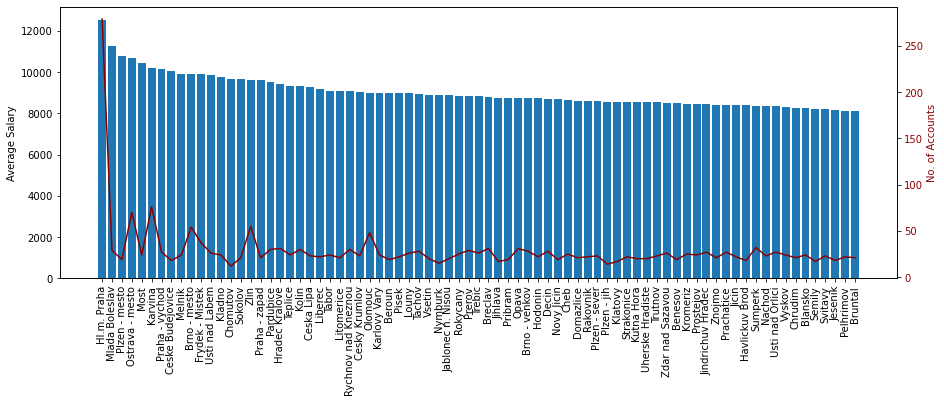

In [44]:
district_acct =district_acct.sort_values(by=['avg_salary'], ascending=False)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(district_acct['name'], district_acct['avg_salary'])
ax.set_ylabel('Average Salary')
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.set_ylabel('No. of Accounts', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.plot(district_acct['name'], district_acct['acct_count'], color = 'darkred' )

plt.show()

In [192]:
district_acct.to_csv("../data/interim/district_acct.csv", index_label = False)

In [45]:
avg_salary_region = district_acct.groupby('region')['avg_salary'].mean()
avg_salary_region.head()

region
Prague             12541.000000
central Bohemia     9357.250000
east Bohemia        8611.181818
north Bohemia       9334.200000
north Moravia       9049.181818
Name: avg_salary, dtype: float64

In [46]:
total_acct_region = district_acct.groupby('region')['acct_count'].sum()
total_acct_region.head()

region
Prague             279
central Bohemia    269
east Bohemia       265
north Bohemia      226
north Moravia      401
Name: acct_count, dtype: int64

In [47]:
region_info = pd.merge(avg_salary_region, total_acct_region, on='region', how='inner')
region_info = region_info.reset_index()


In [48]:
region_info = region_info.sort_values(by=['avg_salary'], ascending = False)

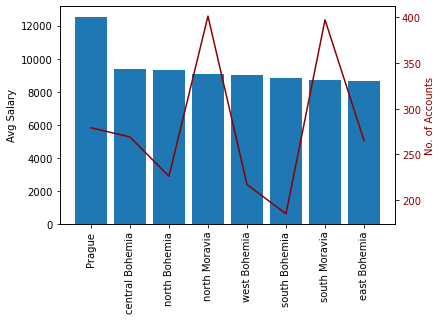

In [49]:
fig, ax = plt.subplots()
ax.bar(region_info['region'], region_info['avg_salary'])
ax.set_ylabel('Avg Salary')
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.set_ylabel('No. of Accounts', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.plot(region_info['region'], region_info['acct_count'], color = 'darkred' )

plt.show()

In [50]:
# Dropping unused columns from district table
cols_to_drop= [
    "unemployment_rate95",
    "crimes95",
    "name"
]
district = district.drop(list(cols_to_drop), axis=1)

### Order Table

In [52]:
order = pd.read_csv("../data/raw/order.asc", sep=';')

In [53]:
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [54]:
order.loc[order['k_symbol']=='SIPO', 'k_symbol'] = 'Household'
order.loc[order['k_symbol']=='POJISTNE', 'k_symbol'] = 'Insurance'
order.loc[order['k_symbol']=='LEASING', 'k_symbol'] = 'Leasing'
order.loc[order['k_symbol']=='UVER', 'k_symbol'] = 'Loan'

In [55]:
order.loc[~ order['k_symbol'].isin(["Household","Loan","Insurance","Leasing"]), 'k_symbol'] = 'Unknown'

In [56]:
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,Household
1,29402,2,ST,89597016,3372.7,Loan
2,29403,2,QR,13943797,7266.0,Household
3,29404,3,WX,83084338,1135.0,Household
4,29405,3,CD,24485939,327.0,Unknown


In [57]:
y_min_lim = order.groupby('k_symbol')['amount'].sum().min()/1000000
y_max_lim = order.groupby('k_symbol')['amount'].sum().max()/1000000
order.groupby('k_symbol')['k_symbol','amount'].sum()

C:\Users\PROMAN~1\AppData\Local\Temp/ipykernel_9724/4255197849.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  order.groupby('k_symbol')['k_symbol','amount'].sum()


,amount
k_symbol,
Household,13965417.0
Insurance,686927.0
Leasing,759527.1
Loan,3035184.5
Unknown,2781938.0


C:\Users\PROMAN~1\AppData\Local\Temp/ipykernel_9724/1114111479.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  order.groupby('k_symbol')['k_symbol','amount'].sum().plot.bar()


<AxesSubplot:xlabel='k_symbol'>

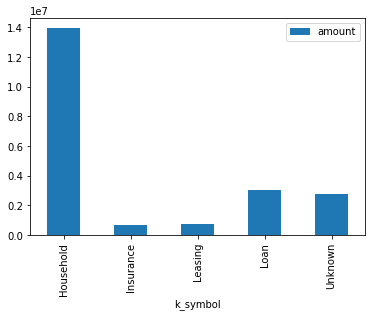

In [58]:

y_max_lim = order.groupby('k_symbol')['amount'].sum().max()/1000000
order.groupby('k_symbol')['k_symbol','amount'].sum().plot.bar()

In [59]:
order = order.drop(['order_id','account_to', 'bank_to'], axis=1)

In [60]:
order.head()

,account_id,amount,k_symbol
0,1,2452.0,Household
1,2,3372.7,Loan
2,2,7266.0,Household
3,3,1135.0,Household
4,3,327.0,Unknown


In [61]:
order_act_count = pd.DataFrame(order.groupby('account_id')['account_id'].count())

In [62]:
order_act_count.reset_index
order_act_count = order_act_count.rename({"account_id":"order_count"}, axis=1)


In [63]:
order.head()

,account_id,amount,k_symbol
0,1,2452.0,Household
1,2,3372.7,Loan
2,2,7266.0,Household
3,3,1135.0,Household
4,3,327.0,Unknown


In [64]:
# Pivoting k_symbol with account id to get the amount of money paid by account 
order = order.pivot_table(index=['account_id'], columns=['k_symbol'], 
                        aggfunc='sum', fill_value=0)

In [65]:
# CODE REFERENCE: 
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns/55757002#55757002
order.columns = ["_".join(a) for a in order.columns.to_flat_index()]

In [66]:
order.head()

,amount_Household,amount_Insurance,amount_Leasing,amount_Loan,amount_Unknown
account_id,,,,,
1,2452,0,0.0,0.0,0
2,7266,0,0.0,3372.7,0
3,1135,3539,0.0,0.0,327
4,3363,0,0.0,0.0,0
5,2668,0,0.0,0.0,0


In [67]:
order = pd.merge(order, order_act_count, on="account_id", how="left")

In [68]:
order.head(10)

,amount_Household,amount_Insurance,amount_Leasing,amount_Loan,amount_Unknown,order_count
account_id,,,,,,
1,2452,0,0.0,0.0,0,1
2,7266,0,0.0,3372.7,0,2
3,1135,3539,0.0,0.0,327,3
4,3363,0,0.0,0.0,0,2
5,2668,0,0.0,0.0,0,1
6,3954,0,0.0,0.0,0,1
7,4880,0,0.0,0.0,0,1
8,2612,0,0.0,0.0,6712,2
10,7033,0,1344.0,0.0,0,2


In [69]:
order['total_amount'] = order['amount_Household'] + order['amount_Insurance'] + order['amount_Leasing'] + order['amount_Loan'] + order['amount_Unknown']

In [70]:
order.head()

,amount_Household,amount_Insurance,amount_Leasing,amount_Loan,amount_Unknown,order_count,total_amount
account_id,,,,,,,
1,2452,0,0.0,0.0,0,1,2452.0
2,7266,0,0.0,3372.7,0,2,10638.7
3,1135,3539,0.0,0.0,327,3,5001.0
4,3363,0,0.0,0.0,0,2,3363.0
5,2668,0,0.0,0.0,0,1,2668.0


In [71]:
acct_disp_card_order = pd.merge(acct_disp_card, order, on="account_id", how="left")

In [72]:
acct_disp_card_order.head()

,account_id,district_id,frequency,date,year,month,disp_id,client_id,type,card_type,card_issue_year,credit_card,lor,amount_Household,amount_Insurance,amount_Leasing,amount_Loan,amount_Unknown,order_count,total_amount
0,576,55,Monthly,930101,1993,1,692,692,OWNER,Not Available,0,0,3,3662.0,0.0,0.0,0.0,0.0,1.0,3662.0
1,3818,74,Monthly,930101,1993,1,4601,4601,OWNER,Not Available,0,0,3,3596.0,4065.0,0.0,0.0,1474.0,3.0,9135.0
2,704,55,Monthly,930101,1993,1,844,844,OWNER,Not Available,0,0,3,2141.0,0.0,0.0,0.0,1197.0,2.0,3338.0
3,2378,16,Monthly,930101,1993,1,2873,2873,OWNER,Not Available,0,0,3,9612.0,0.0,0.0,0.0,0.0,1.0,9612.0
4,2632,24,Monthly,930102,1993,1,3177,3177,OWNER,Not Available,0,0,3,2042.0,2300.0,0.0,0.0,41.0,3.0,4383.0


## Merging Client Table

In [73]:
client = client.drop(['district_id', 'birth_day', 'birth_month', 'birth_year'], axis=1)

In [74]:
acct_disp_card_order_client = pd.merge(acct_disp_card_order, client, on="client_id", how="inner")

In [75]:
acct_disp_card_order_client.head()

,account_id,district_id,frequency,date,year,month,disp_id,client_id,type,card_type,...,amount_Household,amount_Insurance,amount_Leasing,amount_Loan,amount_Unknown,order_count,total_amount,gender,age,age_group
0,576,55,Monthly,930101,1993,1,692,692,OWNER,Not Available,...,3662.0,0.0,0.0,0.0,0.0,1.0,3662.0,F,60,60
1,3818,74,Monthly,930101,1993,1,4601,4601,OWNER,Not Available,...,3596.0,4065.0,0.0,0.0,1474.0,3.0,9135.0,M,61,60
2,704,55,Monthly,930101,1993,1,844,844,OWNER,Not Available,...,2141.0,0.0,0.0,0.0,1197.0,2.0,3338.0,M,51,50
3,2378,16,Monthly,930101,1993,1,2873,2873,OWNER,Not Available,...,9612.0,0.0,0.0,0.0,0.0,1.0,9612.0,F,21,20
4,2632,24,Monthly,930102,1993,1,3177,3177,OWNER,Not Available,...,2042.0,2300.0,0.0,0.0,41.0,3.0,4383.0,M,58,50


In [191]:
acct_disp_card_order_client.to_csv("../data/interim/acct_disp_card_order_client.csv", index_label = False)

<AxesSubplot:xlabel='lor'>

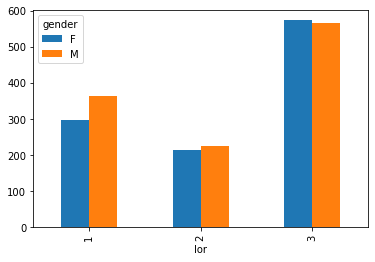

In [76]:
acct_by_lor = acct_disp_card_order_client.groupby(['gender', 'lor'])['account_id'].count()
acct_by_lor.unstack('gender').plot.bar()

<AxesSubplot:xlabel='age_group'>

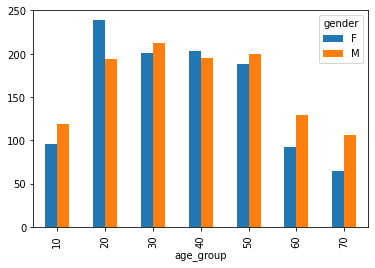

In [77]:
acct_by_agegroup = acct_disp_card_order_client.groupby(['age_group', 'gender'])['account_id'].count()
acct_by_agegroup.unstack('gender').plot.bar()

### Loan Table

In [80]:
loan = pd.read_csv("../data/raw/loan.asc", sep=';')


In [81]:
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [82]:
loan.isna().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

In [83]:
# Taking into account loans that have finished before '96 due to unknown status
loan['ending_year'] = loan['date'].astype(str).str[:2].astype(int) + loan['duration']/12 + 1900
loan['ending_year'] = loan['ending_year'].astype(int)

In [84]:
loan.head()

,loan_id,account_id,date,amount,duration,payments,status,ending_year
0,5314,1787,930705,96396,12,8033.0,B,1994
1,5316,1801,930711,165960,36,4610.0,A,1996
2,6863,9188,930728,127080,60,2118.0,A,1998
3,5325,1843,930803,105804,36,2939.0,A,1996
4,7240,11013,930906,274740,60,4579.0,A,1998


In [85]:
loan = loan.loc[loan['date'].astype(str).str[:2] == '96', :]

In [86]:
loan = loan.rename({"amount":"loan_amount", "duration":"loan_duration", "date":"loan_date", 
                    "ending_year": "loan_ending_year", "status": "loan_status",
                   "payments": "loan_payments"}, axis=1)

<AxesSubplot:ylabel='loan_id'>

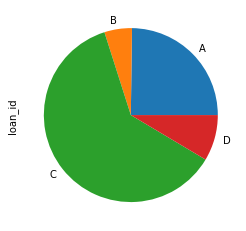

In [87]:
loan.groupby('loan_status')['loan_id'].count().plot.pie()

<AxesSubplot:xlabel='loan_duration'>

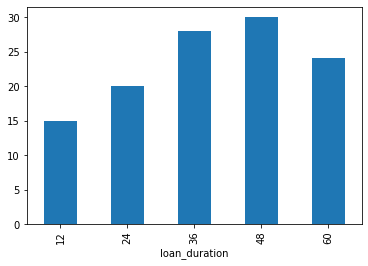

In [88]:
loan.groupby('loan_duration')['loan_id'].count().plot.bar()

In [89]:
loan.groupby(['account_id'])['loan_id'].count()

account_id
19       1
67       1
132      1
501      1
544      1
        ..
11054    1
11138    1
11186    1
11359    1
11362    1
Name: loan_id, Length: 117, dtype: int64

In [90]:
loan.shape
# There's one loan per account 

(117, 8)

In [91]:
temp = pd.merge(acct_disp_card_order_client, loan, on="account_id", how="inner")
temp.shape

(84, 30)

In [92]:
# Loans per age group only taking into consideration accounts that opened before 1996
loan_per_agegroup = pd.DataFrame(temp.groupby(['age_group', 'loan_status'])['loan_id'].count())
loan_per_agegroup
loan_per_agegroup.pivot_table(index='age_group',
                                columns='loan_status',
                                values='loan_id',
                                aggfunc='sum').fillna(0).astype(int)
loan_per_agegroup.unstack('age_group')

loan_id                            
age_group        10    20    30    40   50   60
loan_status                                    
A               2.0   5.0   5.0   2.0  5.0  NaN
B               NaN   NaN   1.0   1.0  2.0  1.0
C               5.0  15.0  11.0  13.0  7.0  NaN
D               1.0   1.0   4.0   NaN  2.0  1.0

<AxesSubplot:xlabel='loan_status', ylabel='Loans count'>

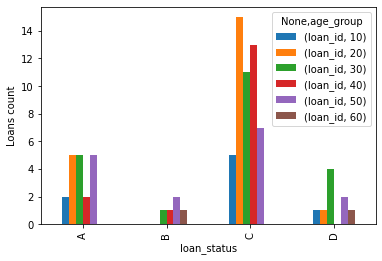

In [93]:
loan_per_agegroup.unstack('age_group').plot.bar(ylabel='Loans count')

In [94]:
loan_per_gender = pd.DataFrame(temp.groupby(['gender', 'loan_status'])['loan_id'].count())
loan_per_gender
loan_per_gender.pivot_table(index='gender',
                                columns='loan_status',
                                values='loan_id',
                                aggfunc='sum').fillna(0).astype(int)
loan_per_gender.unstack('gender')

loan_id    
gender            F   M
loan_status            
A                10   9
B                 4   1
C                24  27
D                 4   5

<AxesSubplot:xlabel='loan_status', ylabel='Loans count'>

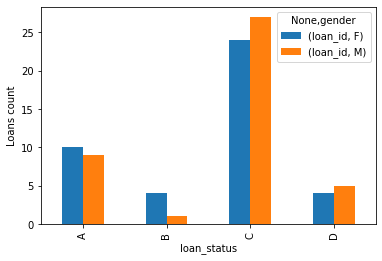

In [95]:
loan_per_gender.unstack('gender').plot.bar(ylabel='Loans count')

In [96]:
loan_per_lor = pd.DataFrame(temp.groupby(['lor', 'loan_status'])['loan_id'].count())
loan_per_lor
loan_per_lor.pivot_table(index='lor',
                                columns='loan_status',
                                values='loan_id',
                                aggfunc='sum').fillna(0).astype(int)
loan_per_lor.unstack('lor')

loan_id      
lor               1     2
loan_status              
A              13.0   6.0
B               5.0   NaN
C              38.0  13.0
D               6.0   3.0

<AxesSubplot:xlabel='loan_status', ylabel='Loans count'>

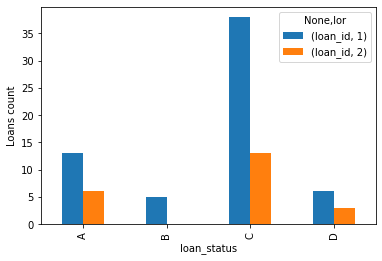

In [97]:
loan_per_lor.unstack('lor').plot.bar(ylabel='Loans count')

In [98]:
loan["loan_recency"] = 12 - loan["loan_date"].astype(str).str[2:4].astype(int) 

### Transactions Table

In [99]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [100]:
trans["k_symbol"].unique()

array([nan, 'DUCHOD', 'UROK', 'SIPO', 'SLUZBY', ' ', 'POJISTNE',
       'SANKC. UROK', 'UVER'], dtype=object)

In [101]:
temp_dict = {
    "POJISTNE": "Insurance",
    "SLUZBY": "Statement",
    "UROK": "Interest",
    "SANKC. UROK": "Negative Interest",
    "SIPO": "Household",
    "DUCHOD": "Pension",
    "UVER": "Loan"
}
 
trans["k_symbol"] = trans["k_symbol"].replace(temp_dict)
trans.loc[trans["k_symbol"].isna(), 'k_symbol'] = 'Unknown'

In [102]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,Unknown,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,Unknown,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,Unknown,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,Unknown,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,Unknown,NaN,NaN


In [103]:
trans["type"] = trans["type"].replace({"PRIJEM":"Credit", "VYDAJ":"Withdrawal"})


In [104]:
trans["trans_year"] = trans["date"].astype(str).str[:2].astype(int)+1900


In [105]:
# Limiting transactions to be at 1996
trans = trans.loc[trans["trans_year"]==1996, :]

In [106]:
trans["trans_year"] = trans["trans_year"].astype(str)

In [107]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,trans_year
252855,732811,2504,960101,Withdrawal,VYBER KARTOU,900.0,38124.4,Unknown,NaN,0.0,1996
252856,800209,2729,960101,Withdrawal,VYBER,1920.0,34202.7,Unknown,NaN,NaN,1996
252857,803553,2738,960101,Withdrawal,VYBER,6500.0,25685.2,Unknown,NaN,NaN,1996
252858,1042686,3566,960101,Withdrawal,VYBER,1000.0,25919.7,Unknown,NaN,NaN,1996
252859,1042689,3566,960101,Withdrawal,VYBER,500.0,25419.7,Unknown,NaN,NaN,1996


In [108]:
# "VYBER KARTOU" credit card withdrawal
# "VKLAD" credit in cash
# "PREVOD Z UCTU" collection from another bank
# "VYBER" withdrawal in cash
# "PREVOD NA UCET" remittance to another bank

operation_dict = {
    "VYBER KARTOU": "CC Withdrawal",
    "VKLAD": "Credit in Cash",
    "PREVOD Z UCTU": "Collect other bank",
    "VYBER": "Cash Withdrawal",
    "PREVOD NA UCET": "Remit to other bank"
}

trans["operation"] = trans["operation"].replace(operation_dict)

In [109]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,trans_year
252855,732811,2504,960101,Withdrawal,CC Withdrawal,900.0,38124.4,Unknown,NaN,0.0,1996
252856,800209,2729,960101,Withdrawal,Cash Withdrawal,1920.0,34202.7,Unknown,NaN,NaN,1996
252857,803553,2738,960101,Withdrawal,Cash Withdrawal,6500.0,25685.2,Unknown,NaN,NaN,1996
252858,1042686,3566,960101,Withdrawal,Cash Withdrawal,1000.0,25919.7,Unknown,NaN,NaN,1996
252859,1042689,3566,960101,Withdrawal,Cash Withdrawal,500.0,25419.7,Unknown,NaN,NaN,1996


In [110]:
trans["trans_month"] = trans["date"].astype(str).str[2:4].astype(int)

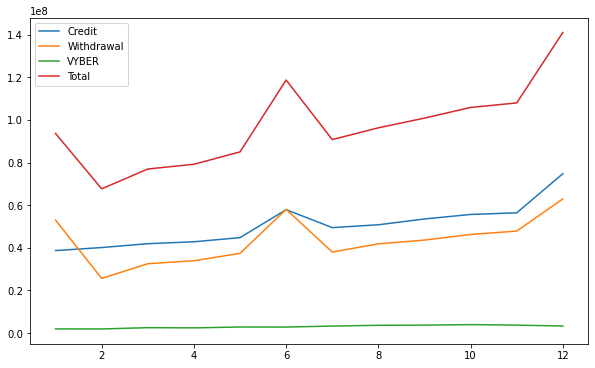

In [111]:
# Group transactions by month
trans_by_month_type = trans.groupby(["trans_month", 'type'])['amount'].agg('sum')
trans_by_month_type = trans_by_month_type.reset_index()
trans_by_month_type
trans_by_month = trans.groupby(["trans_month"])['amount'].agg('sum')
trans_by_month = trans_by_month.reset_index()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(trans_by_month_type[trans_by_month_type["type"]=="Credit"][["trans_month"]], trans_by_month_type[trans_by_month_type["type"]=="Credit"][["amount"]], label= "Credit")
ax.plot(trans_by_month_type[trans_by_month_type["type"]=="Withdrawal"][["trans_month"]], trans_by_month_type[trans_by_month_type["type"]=="Withdrawal"][["amount"]], label="Withdrawal")
ax.plot(trans_by_month_type[trans_by_month_type["type"]=="VYBER"][["trans_month"]], trans_by_month_type[trans_by_month_type["type"]=="VYBER"][["amount"]], label="VYBER")
ax.plot(trans_by_month["trans_month"], trans_by_month["amount"], label = "Total")
plt.legend()
plt.show()

In [190]:
trans_by_month_type.to_csv("../data/interim/trans_by_month_type.csv", index_label = False)


In [112]:
summary_trans_client = trans.groupby('account_id')['amount'].agg(["mean", "max", "min"]).rename({"mean":"trans_amount_avg", "max":"trans_amount_max", "min":"trans_amount_min"}, axis=1)

In [113]:
summary_trans_client.head()

,trans_amount_avg,trans_amount_max,trans_amount_min
account_id,,,
1,1427.637838,3700.0,14.6
2,6624.907059,30354.0,14.6
4,2279.438462,5553.0,14.6
6,2592.236508,11600.0,14.6
7,10376.350000,33975.0,30.4


In [114]:
trans_sum = trans.groupby(['account_id', 'type'])['amount'].sum().unstack('type')

In [115]:
trans_sum.loc[trans_sum['VYBER'].isna(), 'VYBER'] = 0
trans_sum.loc[trans_sum['Credit'].isna(), 'Credit'] = 0
trans_sum.loc[trans_sum['Withdrawal'].isna(), 'Withdrawal'] = 0

In [116]:
trans_sum["Withdrawal"] = trans_sum["VYBER"] + trans_sum["Withdrawal"]
trans_sum = trans_sum.drop(["VYBER"], axis=1)

In [117]:
trans_count = trans.groupby(['account_id', 'type'])['trans_id'].count().unstack('type')
trans_count.head()

type,Credit,VYBER,Withdrawal
account_id,,,
1,29.0,NaN,45.0
2,29.0,5.0,51.0
4,17.0,NaN,22.0
6,24.0,NaN,39.0
7,3.0,NaN,1.0


In [118]:
trans_count.loc[trans_count['VYBER'].isna(), 'VYBER'] = 0

In [119]:
trans_count.head()

type,Credit,VYBER,Withdrawal
account_id,,,
1,29.0,0.0,45.0
2,29.0,5.0,51.0
4,17.0,0.0,22.0
6,24.0,0.0,39.0
7,3.0,0.0,1.0


<BarContainer object of 3 artists>

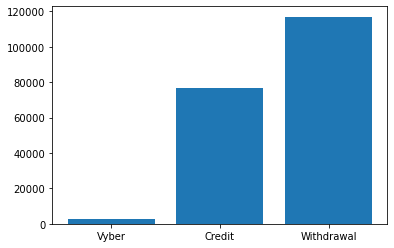

In [120]:
vyber_trans = trans_count['VYBER'].sum()
credit_trans = trans_count['Credit'].sum()
withdrawal_trans = trans_count['Withdrawal'].sum()

plt.bar(["Vyber", "Credit", "Withdrawal"],[vyber_trans, credit_trans, withdrawal_trans])

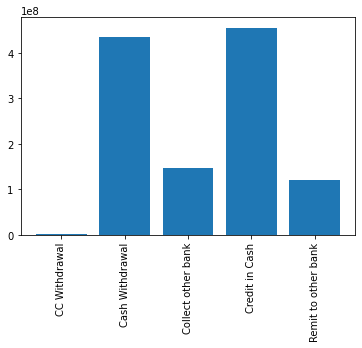

In [121]:
# Graph of operations type
trans_by_operation = trans.groupby('operation')['amount'].sum()
trans_by_operation
fig, ax = plt.subplots()

ax.bar(trans_by_operation.index, trans_by_operation)
plt.xticks(rotation="vertical")
plt.show()

In [122]:
trans_pv_operation = trans.pivot_table(index='account_id', columns='operation', values='amount', aggfunc='sum').fillna(0).astype(int)
trans_pv_operation.columns = [a.replace(" ", "_") for a in trans_pv_operation.columns]
trans_pv_operation.columns = [f"oper_{a}_amt" for a in trans_pv_operation.columns]
trans_pv_operation

,oper_CC_Withdrawal_amt,oper_Cash_Withdrawal_amt,oper_Collect_other_bank_amt,oper_Credit_in_Cash_amt,oper_Remit_to_other_bank_amt
account_id,,,,,
1,0,26155,44148,5100,29424
2,0,187382,263068,23500,87192
4,0,13877,55530,800,18100
6,0,34355,80028,0,47448
7,0,6600,0,34875,0
...,...,...,...,...,...
11333,0,407902,0,422471,0
11349,0,328081,545844,3100,214608
11359,12300,259741,351182,0,79775


In [123]:
trans_pv = trans.pivot_table(index='trans_year', columns='k_symbol', values='trans_id', aggfunc='count').fillna(0).astype(int)
trans_pv

k_symbol,,Household,Insurance,Interest,Loan,Negative Interest,Pension,Statement,Unknown
trans_year,,,,,,,,,
1996,9677,21211,3314,34548,2363,188,5631,28991,90856


<AxesSubplot:xlabel='trans_year'>

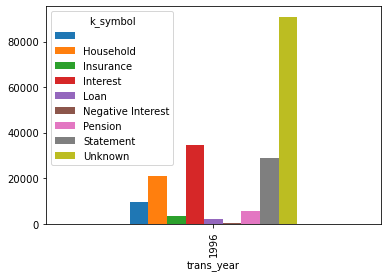

In [124]:
trans_pv.plot.bar()

In [125]:
trans_pv_acct = trans.pivot_table(index='account_id', columns='k_symbol', values='amount', aggfunc='sum').fillna(0).astype(int)
trans_pv_acct = trans_pv_acct.rename({" ":"No Description"}, axis=1)
trans_pv_acct
trans_pv_acct.columns = [f"trans_{a}_amt" for a in trans_pv_acct.columns]
trans_pv_acct

,trans_No Description_amt,trans_Household_amt,trans_Insurance_amt,trans_Interest_amt,trans_Loan_amt,trans_Negative Interest_amt,trans_Pension_amt,trans_Statement_amt,trans_Unknown_amt
account_id,,,,,,,,,
1,0,29424,0,818,0,0,0,175,75228
2,0,87192,0,1974,0,0,0,175,473775
4,7710,10390,0,590,0,0,55530,87,14590
6,0,47448,0,1479,0,0,80028,175,34180
7,0,0,0,30,0,0,0,0,41475
...,...,...,...,...,...,...,...,...,...
11333,0,0,0,3556,0,0,0,175,830198
11349,0,130632,0,2327,83976,0,0,360,876665
11359,3048,54216,0,1595,22511,0,0,175,623048


In [126]:
acct_freq = pd.DataFrame(trans.groupby('account_id')['trans_id'].count())
acct_freq = acct_freq.rename({'trans_id': 'Frequency'}, axis=1)
acct_freq.reset_index()
acct_freq

,Frequency
account_id,
1,74
2,85
4,39
6,63
7,4
...,...
11333,88
11349,88
11359,95


In [127]:
trans['trans_month'] = trans['date'].astype(str).str[2:4].astype(int)
trans['recency'] = 12- trans['trans_month']
acct_recency = pd.DataFrame(trans.groupby('account_id')['recency'].min().sort_values(ascending= False))

In [128]:
acct_recency

,recency
account_id,
799,4
3823,4
182,4
1720,3
3139,2
...,...
1576,0
1577,0
1578,0


In [129]:
rf = pd.merge(acct_freq, acct_recency, on="account_id", how="inner")
rfm = pd.merge(rf, trans_sum, on="account_id", how="inner") 

In [130]:
# Obtaining total monetary value by substracting credit with withdrawal
rfm["Total_MV"] = rfm["Credit"] - rfm["Withdrawal"]


In [131]:
rfm = pd.merge(rfm, summary_trans_client, on="account_id", how="left")

In [132]:
# Merging with amount per type of transaction (k symbol) pivoted 
rfm = pd.merge(rfm, trans_pv_acct, on="account_id", how="left")

In [133]:
rfm = pd.merge(rfm, trans_pv_operation, on="account_id", how="left")

In [134]:
rfm.columns

Index(['Frequency', 'recency', 'Credit', 'Withdrawal', 'Total_MV',
       'trans_amount_avg', 'trans_amount_max', 'trans_amount_min',
       'trans_No Description_amt', 'trans_Household_amt',
       'trans_Insurance_amt', 'trans_Interest_amt', 'trans_Loan_amt',
       'trans_Negative Interest_amt', 'trans_Pension_amt',
       'trans_Statement_amt', 'trans_Unknown_amt', 'oper_CC_Withdrawal_amt',
       'oper_Cash_Withdrawal_amt', 'oper_Collect_other_bank_amt',
       'oper_Credit_in_Cash_amt', 'oper_Remit_to_other_bank_amt'],
      dtype='object')

In [135]:
# Ranking an account based on its quantiles from 1 to 5 under the monetary value category
rfm["Monetary_Categ"] = pd.qcut((rfm["Total_MV"]), q=[0,0.2, 0.4, 0.6, 0.8], labels=["1","2", "3", "4"])


In [136]:
rfm["Monetary_Categ"] = rfm["Monetary_Categ"].astype(str)

In [137]:
rfm.loc[rfm["Monetary_Categ"] == "nan", "Monetary_Categ"] = "5"


In [138]:
# Ranking an account based on its quantiles from 1 to 5 under the frequency value category
rfm["Frequency_Categ"] = pd.qcut((rfm["Frequency"]), q=[0,0.2, 0.4, 0.6, 0.8], labels=["1","2", "3", "4"])
rfm["Frequency_Categ"] = rfm["Frequency_Categ"].astype(str)
rfm.loc[rfm["Frequency_Categ"] == "nan", "Frequency_Categ"] = "5"


In [139]:
# Ranking an account based on its quantiles from 1 to 5 under the recency category

rfm["Recency_Categ"] = "5"
rfm.loc[rfm["recency"]==1, "Recency_Categ"] = "4"
rfm.loc[rfm["recency"]==2, "Recency_Categ"] = "3"
rfm.loc[rfm["recency"]==3, "Recency_Categ"] = "2"
rfm.loc[rfm["recency"]==4, "Recency_Categ"] = "1"

In [140]:
rfm["Monetary_Categ"] = rfm["Monetary_Categ"].astype(int)
rfm["Frequency_Categ"] = rfm["Frequency_Categ"].astype(int)
rfm["Recency_Categ"] =  rfm["Recency_Categ"].astype(int)

In [141]:
# Calculating average between rfm to assign a ranking to an account
rfm["acct_categ"] = (rfm["Monetary_Categ"] + rfm["Frequency_Categ"] + rfm["Recency_Categ"])/3

In [142]:
rfm

,Frequency,recency,Credit,Withdrawal,Total_MV,trans_amount_avg,trans_amount_max,trans_amount_min,trans_No Description_amt,trans_Household_amt,...,trans_Unknown_amt,oper_CC_Withdrawal_amt,oper_Cash_Withdrawal_amt,oper_Collect_other_bank_amt,oper_Credit_in_Cash_amt,oper_Remit_to_other_bank_amt,Monetary_Categ,Frequency_Categ,Recency_Categ,acct_categ
account_id,,,,,,,,,,,,,,,,,,,,,
1,74,0,50066.0,55579.2,-5513.2,1427.637838,3700.0,14.6,0,29424,...,75228,0,26155,44148,5100,29424,1,4,5,3.333333
2,85,0,288542.9,274574.2,13968.7,6624.907059,30354.0,14.6,0,87192,...,473775,0,187382,263068,23500,87192,3,5,5,4.333333
4,39,0,56920.5,31977.6,24942.9,2279.438462,5553.0,14.6,7710,10390,...,14590,0,13877,55530,800,18100,4,2,5,3.666667
6,63,0,81507.7,81803.2,-295.5,2592.236508,11600.0,14.6,0,47448,...,34180,0,34355,80028,0,47448,2,3,5,3.333333
7,4,0,34905.4,6600.0,28305.4,10376.350000,33975.0,30.4,0,0,...,41475,0,6600,0,34875,0,4,1,5,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11333,88,0,426027.5,407902.4,18125.1,9476.476136,47871.0,0.1,0,0,...,830198,0,407902,0,422471,0,4,5,5,4.666667
11349,88,0,551271.3,542689.0,8582.3,12431.367045,64300.0,30.0,0,130632,...,876665,0,328081,545844,3100,214608,3,5,5,4.333333
11359,95,0,352777.0,351816.7,960.3,7416.775789,40521.0,14.6,3048,54216,...,623048,12300,259741,351182,0,79775,2,5,5,4.000000


In [143]:
# Extracting min,max,mean, count of credit
credit_mean = pd.DataFrame(rfm.groupby('account_id')['Credit'].mean()).rename({"Credit": 'avg_credit'}, axis=1)
rfm = pd.merge(rfm, credit_mean, how='inner', on='account_id')

credit_min = pd.DataFrame(rfm.groupby('account_id')['Credit'].min()).rename({"Credit": 'min_credit'}, axis=1)
rfm = pd.merge(rfm, credit_min, how='inner', on='account_id')

credit_max = pd.DataFrame(rfm.groupby('account_id')['Credit'].max()).rename({"Credit": 'max_credit'}, axis=1)
rfm = pd.merge(rfm, credit_max, how='inner', on='account_id')

credit_count = pd.DataFrame(rfm.groupby('account_id')['Credit'].count()).rename({"Credit": 'count_credit'}, axis=1)
rfm = pd.merge(rfm, credit_count, how='inner', on='account_id')

In [144]:
# Extracting min,max,mean, count of withdrawal
withdrawal_mean = pd.DataFrame(rfm.groupby('account_id')['Withdrawal'].mean()).rename({"Withdrawal": 'avg_withdrawal'}, axis=1)
rfm = pd.merge(rfm, withdrawal_mean, how='inner', on='account_id')

withdrawal_min = pd.DataFrame(rfm.groupby('account_id')['Withdrawal'].min()).rename({"Withdrawal": 'min_withdrawal'}, axis=1)
rfm = pd.merge(rfm, withdrawal_min, how='inner', on='account_id')

withdrawal_max = pd.DataFrame(rfm.groupby('account_id')['Withdrawal'].max()).rename({"Withdrawal": 'max_withdrawal'}, axis=1)
rfm = pd.merge(rfm, withdrawal_max, how='inner', on='account_id')

withdrawal_count = pd.DataFrame(rfm.groupby('account_id')['Withdrawal'].count()).rename({"Withdrawal": 'count_withdrawal'}, axis=1)
rfm = pd.merge(rfm, withdrawal_count, how='inner', on='account_id')

In [189]:
rfm.to_csv("../data/interim/rfm.csv", index_label = False)


In [146]:
base_table = pd.merge(acct_disp_card_order_client, rfm, on="account_id", how="left")

In [147]:
base_table.columns

Index(['account_id', 'district_id', 'frequency', 'date', 'year', 'month',
       'disp_id', 'client_id', 'type', 'card_type', 'card_issue_year',
       'credit_card', 'lor', 'amount_Household', 'amount_Insurance',
       'amount_Leasing', 'amount_Loan', 'amount_Unknown', 'order_count',
       'total_amount', 'gender', 'age', 'age_group', 'Frequency', 'recency',
       'Credit', 'Withdrawal', 'Total_MV', 'trans_amount_avg',
       'trans_amount_max', 'trans_amount_min', 'trans_No Description_amt',
       'trans_Household_amt', 'trans_Insurance_amt', 'trans_Interest_amt',
       'trans_Loan_amt', 'trans_Negative Interest_amt', 'trans_Pension_amt',
       'trans_Statement_amt', 'trans_Unknown_amt', 'oper_CC_Withdrawal_amt',
       'oper_Cash_Withdrawal_amt', 'oper_Collect_other_bank_amt',
       'oper_Credit_in_Cash_amt', 'oper_Remit_to_other_bank_amt',
       'Monetary_Categ', 'Frequency_Categ', 'Recency_Categ', 'acct_categ',
       'avg_credit', 'min_credit', 'max_credit', 'count_credit

In [148]:
base_table = pd.merge(base_table, loan, on="account_id", how="left")

In [149]:
base_table = base_table.drop("loan_id", axis=1)

In [150]:
base_table['gender'] = base_table['gender'].replace({'F':'1', 'M':'0'})

In [151]:
base_table.head()

,account_id,district_id,frequency,date,year,month,disp_id,client_id,type,card_type,...,min_withdrawal,max_withdrawal,count_withdrawal,loan_date,loan_amount,loan_duration,loan_payments,loan_status,loan_ending_year,loan_recency
0,576,55,Monthly,930101,1993,1,692,692,OWNER,Not Available,...,70419.2,70419.2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3818,74,Monthly,930101,1993,1,4601,4601,OWNER,Not Available,...,223535.2,223535.2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,704,55,Monthly,930101,1993,1,844,844,OWNER,Not Available,...,218531.2,218531.2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2378,16,Monthly,930101,1993,1,2873,2873,OWNER,Not Available,...,633310.2,633310.2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2632,24,Monthly,930102,1993,1,3177,3177,OWNER,Not Available,...,191071.2,191071.2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


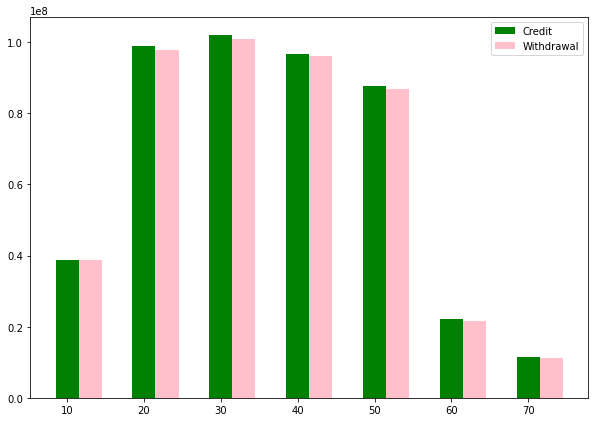

In [152]:
credit_by_agegroup = base_table.groupby('age_group')['Credit'].sum()
withdrawal_by_agegroup = base_table.groupby('age_group')['Withdrawal'].sum()

fig, ax = plt.subplots(figsize=(10,7))

ax.bar(credit_by_agegroup.index, credit_by_agegroup, width=3, color='green', label="Credit")
ax.bar(withdrawal_by_agegroup.index + 3, withdrawal_by_agegroup, width=3, color='pink', label="Withdrawal")

plt.legend()
plt.show()

In [188]:
credit_by_agegroup.to_csv("../data/interim/credit_by_agegroup.csv", index_label = False)
withdrawal_by_agegroup.to_csv("../data/interim/withdrawal_by_agegroup.csv", index_label = False)

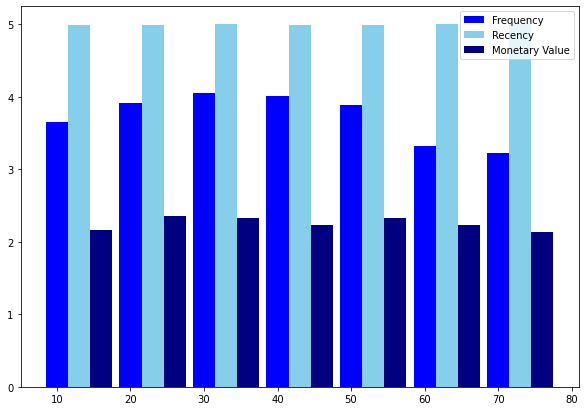

age_group
10    4.990698
20    4.988453
30    5.000000
40    4.992462
50    4.989691
60    5.000000
70    5.000000
Name: Recency_Categ, dtype: float64

In [153]:
# RFM graphs by age group
freq_rank_by_agegroup = base_table.groupby('age_group')['Frequency_Categ'].mean()
recency_rank_by_agegroup = base_table.groupby('age_group')['Recency_Categ'].mean()
monetary_rank_by_agegroup = base_table.groupby('age_group')['Monetary_Categ'].mean()

fig, ax = plt.subplots(figsize=(10,7))

ax.bar(freq_rank_by_agegroup.index, freq_rank_by_agegroup, width=3, color='blue', label="Frequency")
ax.bar(recency_rank_by_agegroup.index + 3, recency_rank_by_agegroup, width=3, color='skyblue', label="Recency")
ax.bar(monetary_rank_by_agegroup.index+6, monetary_rank_by_agegroup, width=3, color="navy", label="Monetary Value")
plt.legend()
plt.show()

recency_rank_by_agegroup

In [187]:
freq_rank_by_agegroup.to_csv("../data/interim/freq_rank_by_agegroup.csv", index_label = False)
recency_rank_by_agegroup.to_csv("../data/processed/recency_rank_by_agegroup.csv", index_label = False)
monetary_rank_by_agegroup.to_csv("../data/processed/monetary_rank_by_agegroup.csv", index_label = False)

# Handling Missing Values

In [154]:
base_table.isna().sum()

account_id             0
district_id            0
frequency              0
date                   0
year                   0
                    ... 
loan_duration       2155
loan_payments       2155
loan_status         2155
loan_ending_year    2155
loan_recency        2155
Length: 64, dtype: int64

In [155]:
base_table.loc[base_table["amount_Household"].isna(), "amount_Household"] = 0
base_table.loc[base_table["amount_Insurance"].isna(), "amount_Insurance"] = 0
base_table.loc[base_table["amount_Leasing"].isna(), "amount_Leasing"] = 0
base_table.loc[base_table["amount_Loan"].isna(), "amount_Loan"] = 0
base_table.loc[base_table["amount_Unknown"].isna(), "amount_Unknown"] = 0

In [156]:
base_table = base_table.drop(["loan_date", "loan_ending_year"], axis=1)

In [157]:
base_table.loc[base_table["loan_duration"].isna(),"loan_duration"] = 0
base_table.loc[base_table["loan_amount"].isna(),"loan_amount"] = 0
base_table.loc[base_table["loan_payments"].isna(),"loan_payments"] = 0
base_table.loc[base_table["loan_status"].isna(),"loan_status"] = "N/A"
base_table.loc[base_table["loan_recency"].isna(),"loan_status"] = 0

In [158]:
base_table = pd.merge(base_table, district, how="left", on="district_id")

# Dependent Variables

In [165]:
granted_loans = pd.read_csv("../data/raw/loan.asc", sep=';')

In [166]:
granted_loans = granted_loans.loc[granted_loans["date"].astype(str).str[:2] == "97", :]

In [167]:
granted_loans["has_loan"] = "1"

In [168]:
granted_loans = granted_loans.drop(list(['loan_id','date', 'amount', 'duration', 'payments',
       'status']), axis=1)

In [169]:
base_table = pd.merge(base_table, granted_loans, on="account_id", how="left")

In [170]:
base_table.loc[base_table["has_loan"].isna(), "has_loan"]= "0"

In [171]:
base_table = base_table.drop("type", axis=1)

In [174]:
client_cc = pd.read_csv("../data/raw/card.asc", sep=';')

In [175]:
client_cc.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [176]:
client_cc = client_cc.loc[client_cc["issued"].astype(str).str[:2] == "97", :]

In [177]:
client_cc["has_cc"] = "1"

In [178]:
client_cc = client_cc.drop(list(['card_id', 'type', 'issued']), axis=1)

In [179]:
base_table = pd.merge(base_table, client_cc, on="disp_id", how="left")

In [180]:
base_table.loc[base_table["has_cc"].isna(), "has_cc"]= "0"

In [181]:
base_table = base_table.drop(list(['account_id', 'district_id','date', 'year', 'month','client_id', 'disp_id']), axis=1)

## Dummy Encoding

In [182]:

base_table.head()


,frequency,card_type,card_issue_year,credit_card,lor,amount_Household,amount_Insurance,amount_Leasing,amount_Loan,amount_Unknown,...,munic_2000_to_9999,munic_10000,cities,ratio_inhab,avg_salary,unemployment_rate96,entrepreneurs_per1000,crimes96,has_loan,has_cc
0,Monthly,Not Available,0,0,3,3662.0,0.0,0.0,0.0,0.0,...,18,0,9,33.9,8743,2.43,111,3894,0,0
1,Monthly,Not Available,0,0,3,3596.0,4065.0,0.0,0.0,1474.0,...,0,1,1,100.0,10673,5.44,100,18347,0,0
2,Monthly,Not Available,0,0,3,2141.0,0.0,0.0,0.0,1197.0,...,18,0,9,33.9,8743,2.43,111,3894,0,0
3,Monthly,Not Available,0,0,3,9612.0,0.0,0.0,0.0,0.0,...,10,1,8,56.9,8427,1.54,107,1913,0,0
4,Monthly,Not Available,0,0,3,2042.0,2300.0,0.0,0.0,41.0,...,6,2,8,80.0,8991,2.01,128,5273,0,0


In [183]:
base_table = pd.get_dummies(base_table, columns=["frequency", "card_type", "region"], drop_first= True)

In [184]:
base_table.shape

(2239, 77)

In [186]:
base_table.to_csv("../data/processed/base_table.csv", index_label = False)